# GPT-2 Fine-Tuning

In [11]:
!pip install transformers nltk rouge-score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## 1 Предобработка данных

Очистим данные от переносов строк, html-тэгов, url'ов и т.п.

In [4]:
import pandas as pd
import numpy as np
import torch
import re

In [13]:
def cleaning(s):
    s = str(s)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace("strong>","")
    s = s.replace("</strong","")
    s = s.replace("<br/>","")
    s = s.replace("[\w*"," ")

    return s

In [14]:
df = pd.read_csv("/kaggle/input/articles/Articles.csv", encoding="ISO-8859-1") # /kaggle/input/news-articles/Articles.csv
df = df.dropna()
df['CleanArticles'] = df['Article'].apply(lambda text: cleaning(text))
df

,Article,Date,Heading,NewsType,CleanArticles
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business,KARACHI: The Sindh government has decided to b...
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business,HONG KONG: Asian markets started on an upswing...
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business,HONG KONG: Hong Kong shares opened . percent l...
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business,HONG KONG: Asian markets tumbled Tuesday follo...
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business,NEW YORK: US oil prices Monday slipped below a...
...,...,...,...,...,...
2687,strong>DUBAI: Dubai International Airport and ...,3/25/2017,Laptop ban hits Dubai for 11m weekend traveller,business,DUBAI: Dubai International Airport and its fla...
2688,"strong>BEIJING: Former Prime Minister, Shaukat...",3/26/2017,Pak China relations not against any third coun...,business,"BEIJING: Former Prime Minister, Shaukat Aziz s..."
2689,strong>WASHINGTON: Uber has grounded its fleet...,3/26/2017,Uber grounds self driving cars after accid,business,WASHINGTON: Uber has grounded its fleet of sel...
2690,strong>BEIJING: The New Development Bank plans...,3/27/2017,New Development Bank plans joint investments i...,business,BEIJING: The New Development Bank plans to -fi...


In [15]:
from sklearn.model_selection import train_test_split

texts_prepared = df['CleanArticles']
# Разбиение на train, val и test
train_texts, val_texts = train_test_split(
    texts_prepared,
    test_size=0.3,
    random_state=42
)
# val_texts, test_texts = train_test_split(
#     temp_texts,
#     test_size=0.5,
#     random_state=42
# )

print(f"Длина train: {len(train_texts)}")
print(f"Длина val: {len(val_texts)}")
#print(f"Длина test: {len(test_texts)}")

Длина train: 1884
Длина val: 808


In [16]:
writer = open('train_texts.txt', 'w')
for text in train_texts:
    writer.write(text)
writer.close()

writer = open('val_texts.txt', 'w')
for text in val_texts:
    writer.write(text)
writer.close()

## 2 Обучение

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [18]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import AutoTokenizer, AutoModelForCausalLM # GPT2LMHeadModel # GPT2Tokenizer, 
from transformers import Trainer, TrainingArguments

In [19]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator

def train(train_dataset,
          model,
          tokenizer,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps,
          optimizer,
          scheduler,
          logging_strategy,
          # save_strategy,
          slice_train_dataset=None
         ):
    data_collator = load_data_collator(tokenizer)
    tokenizer.save_pretrained(output_dir)
    model.save_pretrained(output_dir)

    if slice_train_dataset is not None:
        train_dataset = train_dataset[:slice_train_dataset]

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        logging_strategy='epoch',
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        optimizers=(optimizer, scheduler)
    )

    trainer.train()
    trainer.save_model()

    return trainer.state

### Optimizer - Adam, без scheduler'а

In [22]:
train_file_path = "train_texts.txt"
model_name = 'gpt2'
model_adam_no_scheduler_dir = '/model_adam_no_scheduler' #'/kaggle/working/model_adam_no_scheduler'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 10.0
save_steps = 500
seq_len = 2**7
logging_strategy='epoch'
save_strategy='epoch'
# slice_train_dataset=500

tokenizer = AutoTokenizer.from_pretrained("gpt2")
train_dataset = load_dataset(train_file_path, tokenizer, seq_len)
model_adam_no_scheduler = AutoModelForCausalLM.from_pretrained(model_name)
optimizer = torch.optim.AdamW(model_adam_no_scheduler.parameters(), lr=5e-5)
scheduler = None

/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
import time

In [ ]:
start = time.time()
logs_adam_no_scheduler = train(
    train_dataset=train_dataset,
    model=model_adam_no_scheduler,
    tokenizer=tokenizer,
    output_dir=model_adam_no_scheduler_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    optimizer=optimizer,
    scheduler=scheduler,
    logging_strategy=logging_strategy,
    # save_strategy=save_strategy,
    # slice_train_dataset=slice_train_dataset
)
finish = time.time()
res_time1 = (finish - start)/60
print(f'Время обучения модели: {round(res_time1, 2)} мин')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
350,3.696700
700,3.313900
1050,3.135900
1400,3.007600
1750,2.907200
2100,2.825000
2450,2.762800
2800,2.713000
3150,2.677100
3500,2.654300


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Время обучения модели: 26.43 мин


In [25]:
logs_adam_no_scheduler.log_history

[{'loss': 3.6967,
  'grad_norm': 7.990057945251465,
  'learning_rate': 4.5e-05,
  'epoch': 1.0,
  'step': 350},
 {'loss': 3.3139,
  'grad_norm': 6.965691089630127,
  'learning_rate': 4e-05,
  'epoch': 2.0,
  'step': 700},
 {'loss': 3.1359,
  'grad_norm': 8.205936431884766,
  'learning_rate': 3.5e-05,
  'epoch': 3.0,
  'step': 1050},
 {'loss': 3.0076,
  'grad_norm': 7.032474040985107,
  'learning_rate': 3e-05,
  'epoch': 4.0,
  'step': 1400},
 {'loss': 2.9072,
  'grad_norm': 7.0717549324035645,
  'learning_rate': 2.5e-05,
  'epoch': 5.0,
  'step': 1750},
 {'loss': 2.825,
  'grad_norm': 6.947563648223877,
  'learning_rate': 2e-05,
  'epoch': 6.0,
  'step': 2100},
 {'loss': 2.7628,
  'grad_norm': 7.126166343688965,
  'learning_rate': 1.5e-05,
  'epoch': 7.0,
  'step': 2450},
 {'loss': 2.713,
  'grad_norm': 7.5532026290893555,
  'learning_rate': 1e-05,
  'epoch': 8.0,
  'step': 2800},
 {'loss': 2.6771,
  'grad_norm': 6.752681255340576,
  'learning_rate': 5e-06,
  'epoch': 9.0,
  'step': 31

### Optimizer - Adam, с scheduler'ом linear

In [28]:
from transformers import get_linear_schedule_with_warmup

model_adam_linear_dir = '/model_adam_linear'
model_adam_linear = AutoModelForCausalLM.from_pretrained(model_name)
optimizer = torch.optim.AdamW(model_adam_linear.parameters(), lr=5e-5)
# Инициализация scheduler'а
total_steps = len(train_dataset)*num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

In [29]:
start = time.time()
logs_adam_linear = train(
    train_dataset=train_dataset,
    model=model_adam_linear,
    tokenizer=tokenizer,
    output_dir=model_adam_linear_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    optimizer=optimizer,
    scheduler=scheduler,
    logging_strategy=logging_strategy,
    # save_strategy=save_strategy,
)
finish = time.time()
res_time2 = (finish - start)/60
print(f'Время обучения модели: {round(res_time2, 2)} мин')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
350,3.800000
700,3.339700
1050,3.136500
1400,2.978600
1750,2.842400
2100,2.717400
2450,2.603800
2800,2.496200
3150,2.394900
3500,2.299500


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Время обучения модели: 26.61 мин


In [34]:
logs_adam_linear

TrainerState(epoch=10.0, global_step=3500, max_steps=3500, logging_steps=500, eval_steps=500, save_steps=500, train_batch_size=16, num_train_epochs=10, num_input_tokens_seen=0, total_flos=3650902917120000.0, log_history=[{'loss': 3.8, 'grad_norm': 8.968942642211914, 'learning_rate': 4.977594550994802e-05, 'epoch': 1.0, 'step': 350}, {'loss': 3.3397, 'grad_norm': 7.491008281707764, 'learning_rate': 4.9462269223875244e-05, 'epoch': 2.0, 'step': 700}, {'loss': 3.1365, 'grad_norm': 8.509921073913574, 'learning_rate': 4.914859293780247e-05, 'epoch': 3.0, 'step': 1050}, {'loss': 2.9786, 'grad_norm': 6.852645397186279, 'learning_rate': 4.88349166517297e-05, 'epoch': 4.0, 'step': 1400}, {'loss': 2.8424, 'grad_norm': 6.740859031677246, 'learning_rate': 4.852124036565693e-05, 'epoch': 5.0, 'step': 1750}, {'loss': 2.7174, 'grad_norm': 6.098780155181885, 'learning_rate': 4.820756407958416e-05, 'epoch': 6.0, 'step': 2100}, {'loss': 2.6038, 'grad_norm': 6.201688766479492, 'learning_rate': 4.78938877

In [33]:
logs_adam_linear.log_history

[{'loss': 3.8,
  'grad_norm': 8.968942642211914,
  'learning_rate': 4.977594550994802e-05,
  'epoch': 1.0,
  'step': 350},
 {'loss': 3.3397,
  'grad_norm': 7.491008281707764,
  'learning_rate': 4.9462269223875244e-05,
  'epoch': 2.0,
  'step': 700},
 {'loss': 3.1365,
  'grad_norm': 8.509921073913574,
  'learning_rate': 4.914859293780247e-05,
  'epoch': 3.0,
  'step': 1050},
 {'loss': 2.9786,
  'grad_norm': 6.852645397186279,
  'learning_rate': 4.88349166517297e-05,
  'epoch': 4.0,
  'step': 1400},
 {'loss': 2.8424,
  'grad_norm': 6.740859031677246,
  'learning_rate': 4.852124036565693e-05,
  'epoch': 5.0,
  'step': 1750},
 {'loss': 2.7174,
  'grad_norm': 6.098780155181885,
  'learning_rate': 4.820756407958416e-05,
  'epoch': 6.0,
  'step': 2100},
 {'loss': 2.6038,
  'grad_norm': 6.201688766479492,
  'learning_rate': 4.7893887793511385e-05,
  'epoch': 7.0,
  'step': 2450},
 {'loss': 2.4962,
  'grad_norm': 6.252501487731934,
  'learning_rate': 4.758021150743861e-05,
  'epoch': 8.0,
  'st

### Optimizer - SGD, без scheduler'а

In [75]:
model_sgd_no_scheduler_dir = '/model_sgd_no_scheduler'
# Инициализация модели и оптимизатора
model_sgd_no_scheduler = AutoModelForCausalLM.from_pretrained(model_name)
optimizer = torch.optim.SGD(model_sgd_no_scheduler.parameters(), lr=1e-4) # при 1e-5 сходилось уж слишком медленно P.S. Уменьшение lr до 1e-4 не сильно помогло
scheduler = None  # Без scheduler'а

In [51]:
start = time.time()
logs_sgd_no_scheduler = train(
    train_dataset=train_dataset,
    model=model_sgd_no_scheduler,
    tokenizer=tokenizer,
    output_dir=model_sgd_no_scheduler_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    optimizer=optimizer,
    scheduler=scheduler,
    logging_strategy=logging_strategy,
    # save_strategy=save_strategy,
)
finish = time.time()
res_time3 = (finish - start)/60
print(f'Время обучения модели: {round(res_time3, 2)} мин')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
350,4.523300
700,4.464300
1050,4.426700
1400,4.401000
1750,4.379000
2100,4.364900
2450,4.354600
2800,4.347900
3150,4.344000
3500,4.342100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Время обучения модели: 24.61 мин


In [52]:
logs_sgd_no_scheduler.log_history

[{'loss': 4.5233,
  'grad_norm': 10.401145935058594,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 350},
 {'loss': 4.4643,
  'grad_norm': 10.275202751159668,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 700},
 {'loss': 4.4267,
  'grad_norm': 11.017559051513672,
  'learning_rate': 7e-05,
  'epoch': 3.0,
  'step': 1050},
 {'loss': 4.401,
  'grad_norm': 10.867061614990234,
  'learning_rate': 6e-05,
  'epoch': 4.0,
  'step': 1400},
 {'loss': 4.379,
  'grad_norm': 10.102063179016113,
  'learning_rate': 5e-05,
  'epoch': 5.0,
  'step': 1750},
 {'loss': 4.3649,
  'grad_norm': 9.974421501159668,
  'learning_rate': 4e-05,
  'epoch': 6.0,
  'step': 2100},
 {'loss': 4.3546,
  'grad_norm': 9.906177520751953,
  'learning_rate': 3e-05,
  'epoch': 7.0,
  'step': 2450},
 {'loss': 4.3479,
  'grad_norm': 10.536182403564453,
  'learning_rate': 2e-05,
  'epoch': 8.0,
  'step': 2800},
 {'loss': 4.344,
  'grad_norm': 9.81413745880127,
  'learning_rate': 1e-05,
  'epoch': 9.0,
  'step': 3150},
 

### Optimizer - RMSProp, без scheduler'а

In [76]:
model_rmsprop_no_scheduler_dir = '/model_rmsprop_no_scheduler'
# Инициализация модели и оптимизатора
model_rmsprop_no_scheduler = AutoModelForCausalLM.from_pretrained(model_name)
optimizer = torch.optim.RMSprop(model_rmsprop_no_scheduler.parameters(), lr=1e-5)
scheduler = None  # Без scheduler'а

In [45]:
start = time.time()
logs_rmsprop_no_scheduler = train(
    train_dataset=train_dataset,
    model=model_rmsprop_no_scheduler,
    tokenizer=tokenizer,
    output_dir=model_rmsprop_no_scheduler_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    optimizer=optimizer,
    scheduler=scheduler,
    logging_strategy=logging_strategy,
    # save_strategy=save_strategy,
)
finish = time.time()
res_time4 = (finish - start)/60
print(f'Время обучения модели: {round(res_time4, 2)} мин')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
350,3.864500
700,3.618700
1050,3.519700
1400,3.454900
1750,3.406900
2100,3.369000
2450,3.342600
2800,3.322400
3150,3.308700
3500,3.301100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Время обучения модели: 25.91 мин


Видно, что сходится медленно. Возможно, слишком малый lr.

In [46]:
logs_rmsprop_no_scheduler.log_history

[{'loss': 3.8645,
  'grad_norm': 11.211100578308105,
  'learning_rate': 9e-06,
  'epoch': 1.0,
  'step': 350},
 {'loss': 3.6187,
  'grad_norm': 10.26350212097168,
  'learning_rate': 8.000000000000001e-06,
  'epoch': 2.0,
  'step': 700},
 {'loss': 3.5197,
  'grad_norm': 11.898200035095215,
  'learning_rate': 7e-06,
  'epoch': 3.0,
  'step': 1050},
 {'loss': 3.4549,
  'grad_norm': 11.232571601867676,
  'learning_rate': 6e-06,
  'epoch': 4.0,
  'step': 1400},
 {'loss': 3.4069,
  'grad_norm': 11.072620391845703,
  'learning_rate': 5e-06,
  'epoch': 5.0,
  'step': 1750},
 {'loss': 3.369,
  'grad_norm': 10.933032035827637,
  'learning_rate': 4.000000000000001e-06,
  'epoch': 6.0,
  'step': 2100},
 {'loss': 3.3426,
  'grad_norm': 10.524871826171875,
  'learning_rate': 3e-06,
  'epoch': 7.0,
  'step': 2450},
 {'loss': 3.3224,
  'grad_norm': 11.08945369720459,
  'learning_rate': 2.0000000000000003e-06,
  'epoch': 8.0,
  'step': 2800},
 {'loss': 3.3087,
  'grad_norm': 10.6177339553833,
  'learni

## Инференс

In [54]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer # любой объект по сути можно использовать, хоть GPT2LMHeadModel, хоть AutoModelForCausalLM

def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model

def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def generate_text(model, tokenizer, sequence, max_length):
    # model.to(device)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids.to(device),
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )
    return tokenizer.decode(final_outputs[0], skip_special_tokens=True)

## Оценка

In [55]:
val_file_path = "val_texts.txt"
val_dataset = load_dataset(val_file_path, tokenizer, seq_len)

/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (304292 > 1024). Running this sequence through the model will result in indexing errors


In [56]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer


def compute_bleu(reference, hypothesis):
    smoothing = SmoothingFunction().method1
    return sentence_bleu([reference], hypothesis, smoothing_function=smoothing)

def compute_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference), ' '.join(hypothesis))
    return {key: round(value.fmeasure, 5) for key, value in scores.items()}

def calculate_perplexity(text, model, tokenizer):
    inputs = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=1024).to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=inputs)
        log_likelihood = outputs.loss * inputs.size(1)
        perplexity = torch.exp(log_likelihood / inputs.size(1))
    return perplexity.item()

### Оценка одного текста, для наглядности

In [57]:
# среднее кол-во слов в текстах датасета
avg_words = int(np.mean([len(text.split(' ')) for text in texts_prepared.values]))
print(f'среднее кол-во слов в датасете: {avg_words}')

среднее кол-во слов в датасете: 287


In [59]:
ref = val_dataset[0]
ref_decoded = tokenizer.decode(ref, skip_special_tokens=True)
ref_decoded

'KATHMANDU: A -year-old Dutch climber died while descending from the summit of Everest, the first to perish this year on the world\'s highest mountain, officials in Nepal said on Saturday.Eric Ary Arnold was among over climbers who reached the , metre , feet) summit on Friday, but died later that day while ming down on high-altitude slopes known as the death zone" because of the prevailing thin air, Tourism Department official Gyanendra Shrestha said.Mingma Sherpa of the Seven Summits Treks mpany that organised Arnold\'s expedition said his client mplained of weakness while'

In [60]:
# model_adam_no_scheduler.to(device)
# я вообще хз как правильно делать. я делаю так: я подаю в модель около половины всей строки, а остальную половину предсказываю моделью.
# оценивать можно метрики по этим целым двум строкам,
# а можно только по второй половине (тогда сравниваются только истинное и сгенеренное)
first_half = int(len(ref_decoded)/2)

#model = load_model(model_adam_no_scheduler_dir)
#tokenizer = load_tokenizer(model_adam_no_scheduler_dir)
generated_text = generate_text(
    model_adam_no_scheduler,
    tokenizer,
    sequence=ref_decoded[:first_half], # подаём половину исходного текста чтобы модель его продолжила
    max_length=len(ref)
)
generated_text

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'KATHMANDU: A -year-old Dutch climber died while descending from the summit of Everest, the first to perish this year on the world\'s highest mountain, officials in Nepal said on Saturday.Eric Ary Arnold was among over climbers who reached the , metre , feet) summit on Friday, but died latrically of a heart attack, a medical source with knowledge of the cause of death said."Eric was a young American born in Taiwan who spent a long time in Nepal," the source said."He was very enthusiastic about climbing Everest and loved climbing," the source said."He worked hard at the hotel and died in'

In [61]:
# целиковые сообщения, наполовину одинаковые
compute_bleu(reference=ref_decoded, hypothesis=generated_text)

0.6828716509535331

In [62]:
# только вторые половины
compute_bleu(reference=ref_decoded[first_half:], hypothesis=generated_text[first_half:])

0.30998602405348685

In [63]:
compute_rouge(reference=ref_decoded, hypothesis=generated_text)

{'rouge1': 0.9393, 'rouge2': 0.72999, 'rougeL': 0.70288}

In [64]:
compute_rouge(reference=ref_decoded[first_half:], hypothesis=generated_text[first_half:])

{'rouge1': 0.8815, 'rouge2': 0.46764, 'rougeL': 0.41996}

In [65]:
# "Perplexity можно интерпретировать как взвешенный коэффициент ветвления.
# Например, если показатель перплексии равен 100, это означает, что когда модели приходится предсказывать следующее слово,
# это приводит её в такую же «растерянность», как если бы ей пришлось выбирать одно из 100 слов."
# Источник: https://habr.com/ru/companies/wunderfund/articles/580230/
calculate_perplexity(ref_decoded, model_adam_no_scheduler, tokenizer)

38.79032516479492

### Оценка для всего val датасета

In [69]:
from tqdm import tqdm

def evaluate_model(model_path, val_dataset):
    model = load_model(model_path).to(device)
    tokenizer = load_tokenizer(model_path)
    
    # TODO мб надо все-атки подгружать модель и токенайзер по пути, как было до этого - done
    bleus = []
    rouge1s = []
    rouge2s = []
    rougeLs = []

    perplexities = []
    
    for ref in tqdm(val_dataset):
        ref_decoded = tokenizer.decode(ref, skip_special_tokens=True)
        first_half = int(len(ref_decoded)/2)
        generated_text = generate_text(
            model,
            tokenizer,
            sequence=ref_decoded[:first_half], # подаём половину исходного текста чтобы модель его продолжила
            max_length=len(ref)
        )
        bleu = compute_bleu(reference=ref_decoded[first_half:], hypothesis=generated_text[first_half:]) # только вторые половины
        rouge = compute_rouge(reference=ref_decoded[first_half:], hypothesis=generated_text[first_half:]) # только вторые половины
        perplexity = calculate_perplexity(ref_decoded, model, tokenizer)
        
        bleus.append(bleu)
        rouge1s.append(rouge['rouge1'])
        rouge2s.append(rouge['rouge2'])
        rougeLs.append(rouge['rougeL'])
        perplexities.append(perplexity)

    result = {
        'Среднее BLEU': np.mean(bleus),
        'Среднее ROUGE 1': np.mean(rouge1s),
        'Среднее ROUGE 2': np.mean(rouge2s),
        'Среднее ROUGE L': np.mean(rougeLs),
        'Среднее Perplexity': np.mean(perplexities)
    }
    
    return result

In [71]:
# я использую какой попало любой токенайзер...но вроде работает - исправил, теперь подгружается токенайзер из папки, в которую сохранял все файлы конкретной модели
# и сначала делаю декодирование сообщения а затем обратно его кодирование зачем-то..ну это для того чтобы половину текста взять по идее? хотя можно по идее половину токенищированного представления подавать, но что-то там было не так
eval_adam_no_scheduler = evaluate_model(model_adam_no_scheduler_dir, val_dataset)

100%|██████████| 2377/2377 [24:30<00:00,  1.62it/s]


In [72]:
eval_adam_no_scheduler

{'Среднее BLEU': 0.30993047176301736,
 'Среднее ROUGE 1': 0.8283308035338662,
 'Среднее ROUGE 2': 0.48147362641985697,
 'Среднее ROUGE L': 0.40875453933529654,
 'Среднее Perplexity': 31.53620655415286}

In [73]:
eval_adam_linear = evaluate_model(model_adam_linear_dir, val_dataset)

100%|██████████| 2377/2377 [24:26<00:00,  1.62it/s]


In [74]:
eval_adam_linear

{'Среднее BLEU': 0.3124115532457447,
 'Среднее ROUGE 1': 0.8300087042490534,
 'Среднее ROUGE 2': 0.4827640302902819,
 'Среднее ROUGE L': 0.40956377787126635,
 'Среднее Perplexity': 31.369263568143158}

In [77]:
eval_sgd_no_scheduler = evaluate_model(model_sgd_no_scheduler_dir, val_dataset)

100%|██████████| 2377/2377 [24:00<00:00,  1.65it/s]


In [78]:
eval_sgd_no_scheduler

{'Среднее BLEU': 0.2879495627338906,
 'Среднее ROUGE 1': 0.7969778544383677,
 'Среднее ROUGE 2': 0.45868367690366,
 'Среднее ROUGE L': 0.396855557425326,
 'Среднее Perplexity': 66.38759447779032}

In [79]:
eval_rmsprop_no_scheduler = evaluate_model(model_rmsprop_no_scheduler_dir, val_dataset)

100%|██████████| 2377/2377 [24:35<00:00,  1.61it/s]


In [80]:
eval_rmsprop_no_scheduler

{'Среднее BLEU': 0.30824507082954505,
 'Среднее ROUGE 1': 0.8279702734539336,
 'Среднее ROUGE 2': 0.4799703281447203,
 'Среднее ROUGE L': 0.40729560370214557,
 'Среднее Perplexity': 31.53620655415286}

### Результаты всех моделей. Графики потерь и метрик.

In [3]:
import matplotlib.pyplot as plt

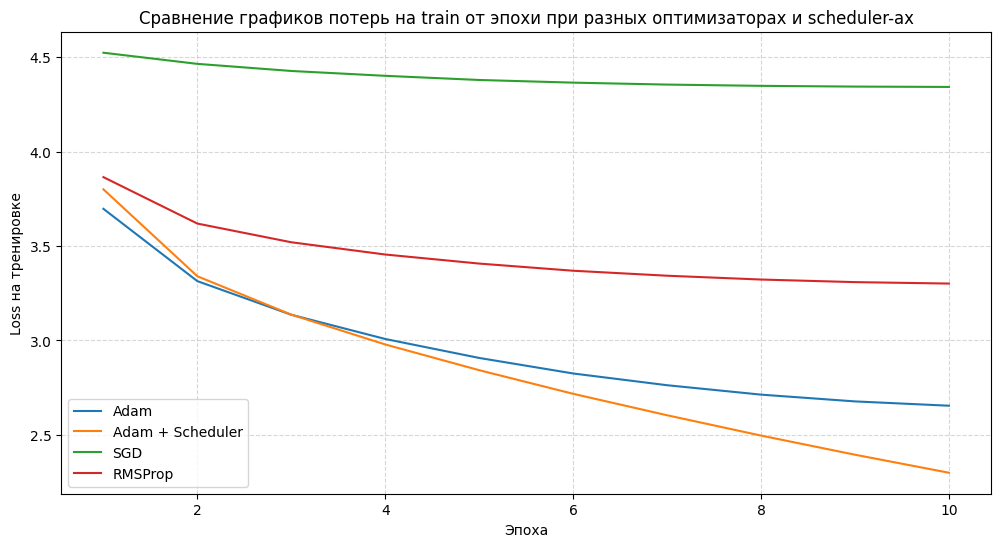

In [ ]:
# Построение графиков потерь на train от эпохи
logs_list = [
    logs_adam_no_scheduler,
    logs_adam_linear,
    logs_sgd_no_scheduler,
    logs_rmsprop_no_scheduler
]

train_losses_adam_no_scheduler = []
train_losses_adam_linear = []
train_losses_sgd_no_scheduler = []
train_losses_rmsprop_no_scheduler = []

train_losses_list = [
    train_losses_adam_no_scheduler,
    train_losses_adam_linear,
    train_losses_sgd_no_scheduler,
    train_losses_rmsprop_no_scheduler
]

for logs, train_losses in zip(logs_list, train_losses_list):
    for lh in logs.log_history[:-1]: # берем все элементы до последнего, так как это информация по эпохам, а последний - это средние значения по всем эпохам
        train_losses.append(lh['loss'])

epochs = range(1, int(num_train_epochs) + 1)

plt.figure(figsize=(12, 6))
labels = ['Adam', 'Adam + Scheduler', 'SGD', 'RMSProp']
for label, train_losses in zip(labels, train_losses_list):
    plt.plot(epochs, train_losses, label=label)
plt.grid(linestyle='--', alpha=0.5)
plt.xlabel('Эпоха')
plt.ylabel('Loss на тренировке')
plt.title('Сравнение графиков потерь на train от эпохи при разных оптимизаторах и scheduler-ах')
plt.legend()
plt.show()

In [101]:
# реорганизуем словарь для вывода...потому что код для вывода уже готовый и под него подгоняю данные
eval_dict = {
    'adam_no_scheduler': eval_adam_no_scheduler,
    'adam_linear': eval_adam_linear,
    'sgd_no_scheduler': eval_sgd_no_scheduler,
    'rmsprop_no_scheduler': eval_rmsprop_no_scheduler
}
#model_names = list(eval_dict.keys())
metric_labels = list(eval_sgd_no_scheduler.keys())

mean_bleus, mean_rouge1s, mean_rouge2s, mean_rougels, mean_perplexities = [], [], [], [], []
model_means_list = [
    mean_bleus, mean_rouge1s, mean_rouge2s, mean_rougels, mean_perplexities
]

# для каждой метрики


for model_eval_stats in eval_dict.values():
    all_metrics_for_this_model = list(eval_dict.values()) # для каждого словаря с средними метриками каждой модели делаем из метрик список
    for metric, model_means in zip(metric_labels, model_means_list):
        model_means.append(model_eval_stats[metric])
    
model_means_for_plot = {
    'Средние BLEU': mean_bleus,
    'Средние ROUGE 1': mean_rouge1s,
    'Средние ROUGE 2': mean_rouge2s,
    'Средние ROUGE L': mean_rougels,
    'Средние Perplexity': mean_perplexities
}

In [ ]:
model_means_for_plot

{'Средние BLEU': [0.30993047176301736,
  0.3124115532457447,
  0.2879495627338906,
  0.30824507082954505],
 'Средние ROUGE 1': [0.8283308035338662,
  0.8300087042490534,
  0.7969778544383677,
  0.8279702734539336],
 'Средние ROUGE 2': [0.48147362641985697,
  0.4827640302902819,
  0.45868367690366,
  0.4799703281447203],
 'Средние ROUGE L': [0.40875453933529654,
  0.40956377787126635,
  0.396855557425326,
  0.40729560370214557],
 'Средние Perplexity': [31.53620655415286,
  31.369263568143158,
  66.38759447779032,
  31.53620655415286]}

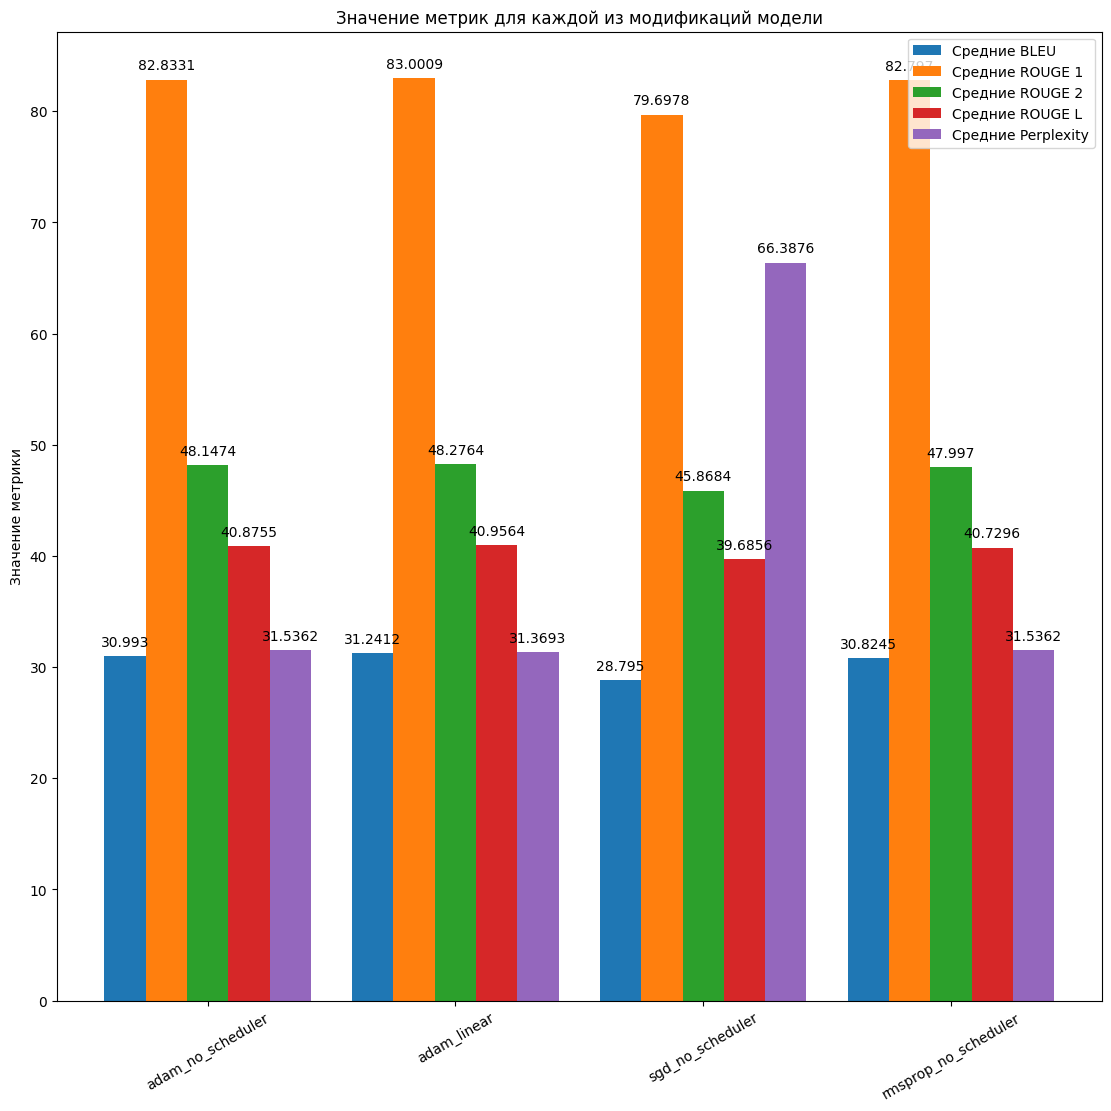

In [8]:
x = np.arange(len(eval_dict))  # the label locations
width = 1/6  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(11, 11))

for attribute, measurement in model_means_for_plot.items():
    if attribute != 'Средние Perplexity':
        measurement = [m*100 for m in measurement] # Шкалируем метрики  из (0,1) в (0,100) для читаемости на графике. Perplexity и так в (0,100).

    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Значение метрики')
ax.set_title('Значение метрик для каждой из модификаций модели')
ax.set_xticks(
    x + 2*width,
    eval_dict.keys(),
    rotation=30
)
ax.legend(
    loc='upper right',
    #ncols=5
)
#ax.set_ylim(0, 250)

plt.show()

Самая лучшая модель это та - у которой низкая perplexity, а остальные метрики - высокие. По такому принципу (да и по характеру loss'а на train) лучшей моделью можно назвать модель с оптимизатором adam и scheduler'ом linear.

Простой функционал для чат-бота можно организовать, нужен цикл, а функция генерации текста уже есть. Но качество модели не супер, поэтому и оборачивать ее в бота не вижу особого смысла..